In [28]:
# Importing important librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
data = pd.read_csv('archive/AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [21]:
data.loc[:, 'Month'] = data['Month'].apply(lambda x: dt(int(x[:4]), int(x[-2:]), 15))

In [22]:
data.head()

,Month,#Passengers
0,1949-01-15,112
1,1949-02-15,118
2,1949-03-15,132
3,1949-04-15,129
4,1949-05-15,121


In [24]:
# Reindex dataset
data.set_index('Month', inplace=True)
data.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


In [25]:
data.index

DatetimeIndex(['1949-01-15', '1949-02-15', '1949-03-15', '1949-04-15',
               '1949-05-15', '1949-06-15', '1949-07-15', '1949-08-15',
               '1949-09-15', '1949-10-15',
               ...
               '1960-03-15', '1960-04-15', '1960-05-15', '1960-06-15',
               '1960-07-15', '1960-08-15', '1960-09-15', '1960-10-15',
               '1960-11-15', '1960-12-15'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

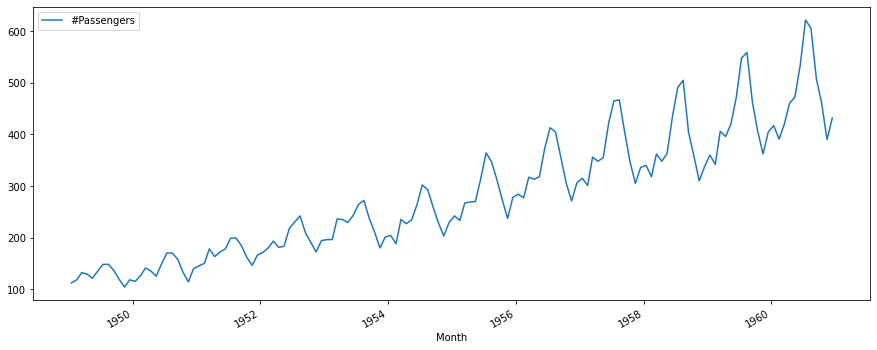

In [27]:
data.plot()
plt.show()

It's a seanal time series

In [30]:
ts = data['#Passengers']

In [32]:
ts

Month
1949-01-15    112
1949-02-15    118
1949-03-15    132
1949-04-15    129
1949-05-15    121
             ... 
1960-08-15    606
1960-09-15    508
1960-10-15    461
1960-11-15    390
1960-12-15    432
Name: #Passengers, Length: 144, dtype: int64

<AxesSubplot:xlabel='Month'>

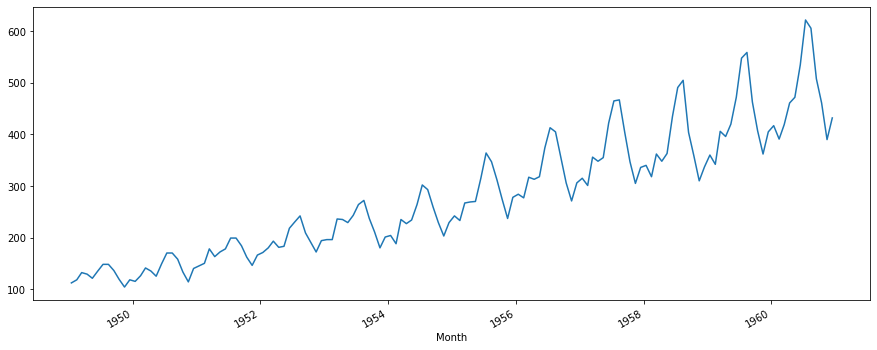

In [33]:
ts.plot()

In [49]:
# Transform the dataset using the logarithm function
ts_log = np.log(ts)
ts_log

Month
1949-01-15    4.718499
1949-02-15    4.770685
1949-03-15    4.882802
1949-04-15    4.859812
1949-05-15    4.795791
                ...   
1960-08-15    6.406880
1960-09-15    6.230481
1960-10-15    6.133398
1960-11-15    5.966147
1960-12-15    6.068426
Name: #Passengers, Length: 144, dtype: float64

In [38]:
# Testing the stationarity
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd  = timeseries.rolling(window=52, center=False).std()
    
    origin = plt.plot(timeseries, c='blue', label='Original data')
    mean   = plt.plot(rolmean, c='red', label='Rolling Mean')
    std    = plt.plot(rolstd, c='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    print('Dickey-Fuller test: ')
    dftest  = adfuller(timeseries, autolag='AIC')
    dfoutput= pd.Series(dftest[:4], index=['Test statistic', 'p-value', '#Lag used', 'Number of observation used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)' %key] = value
        
    print(dfoutput)

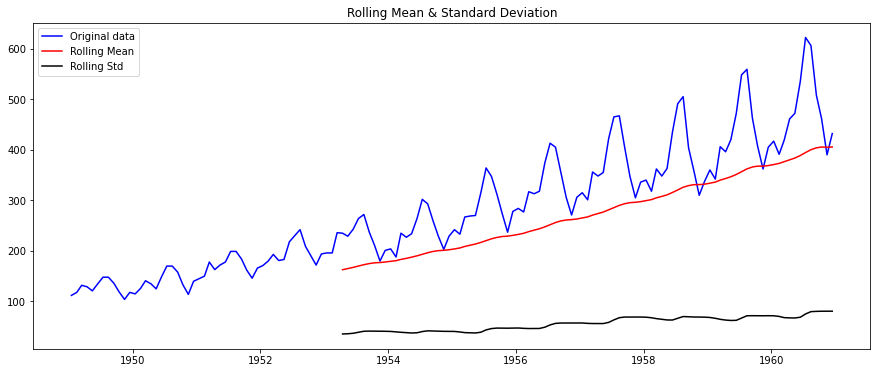

Dickey-Fuller test: 
Test statistic                  0.815369
p-value                         0.991880
#Lag used                      13.000000
Number of observation used    130.000000
Critical Values (1%)           -3.481682
Critical Values (5%)           -2.884042
Critical Values (10%)          -2.578770
dtype: float64


In [40]:
test_stationarity(ts)

### Decomposing data

<AxesSubplot:xlabel='Month'>

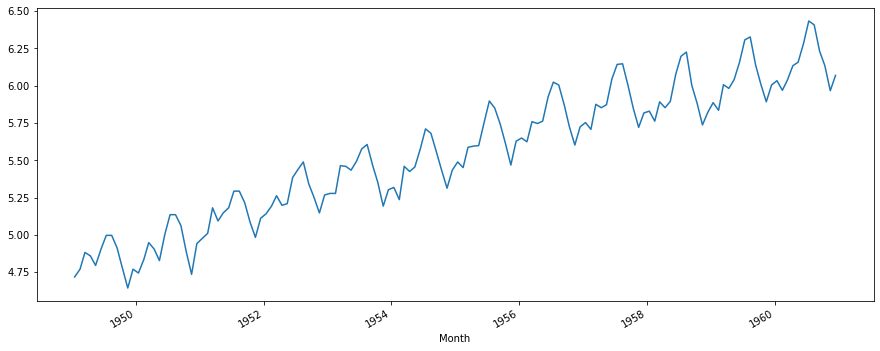

In [41]:
ts_log.plot()

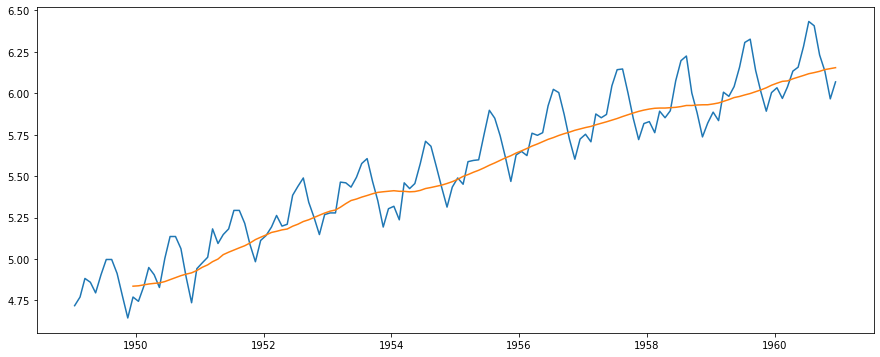

In [44]:
movingAverage = ts_log.rolling(window=12).mean()
movingSTD     = ts_log.rolling(window=12).std()

plt.plot(ts_log, label="ts log original")
plt.plot(movingAverage, label="ts rolling mean")

In [46]:
ts_log_mov_diff = ts_log - movingAverage
ts_log_mov_diff.dropna(inplace=True)
ts_log_mov_diff.head(12)

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
1950-05-15   -0.027529
1950-06-15    0.139881
1950-07-15    0.260184
1950-08-15    0.248635
1950-09-15    0.162937
1950-10-15   -0.018578
1950-11-15   -0.180379
Name: #Passengers, dtype: float64

<AxesSubplot:xlabel='Month'>

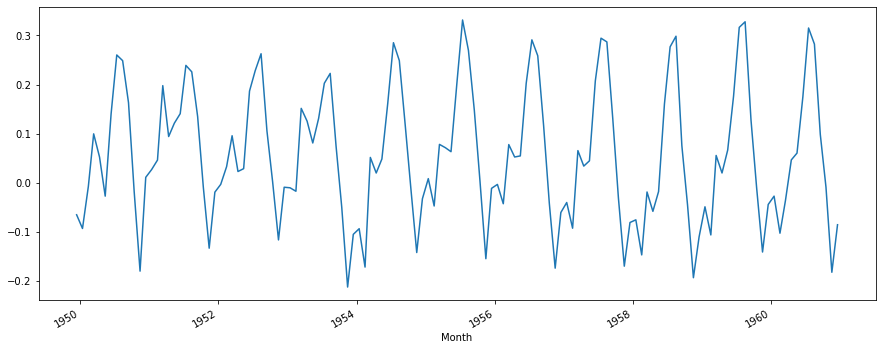

In [47]:
ts_log_mov_diff.plot()

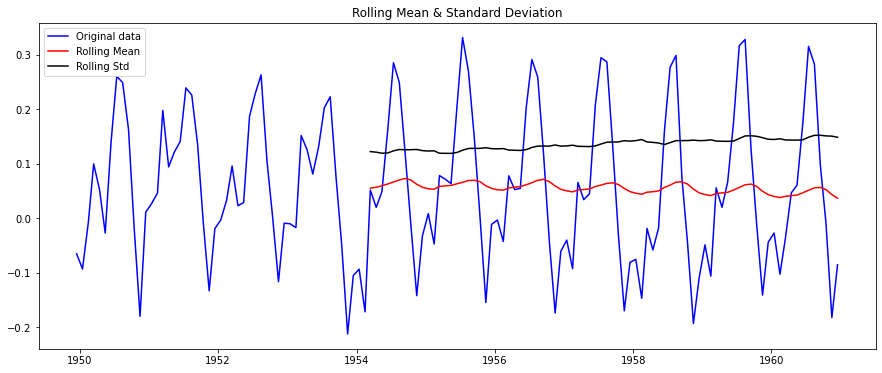

Dickey-Fuller test: 
Test statistic                 -3.162908
p-value                         0.022235
#Lag used                      13.000000
Number of observation used    119.000000
Critical Values (1%)           -3.486535
Critical Values (5%)           -2.886151
Critical Values (10%)          -2.579896
dtype: float64


In [48]:
test_stationarity(ts_log_mov_diff)

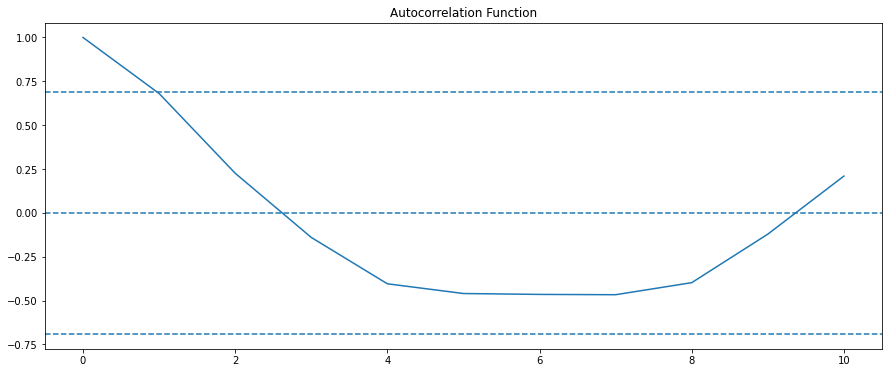


The graphe show that q can be zero(0) or one(1)



In [61]:
# Plot ACF
plt.plot(np.arange(0, 11), acf(ts_log_mov_diff, nlags=10))
plt.axhline(y=0, linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--')
plt.title('Autocorrelation Function')
plt.show()

print("""
The graphe show that q can be zero(0) or one(1)
""")

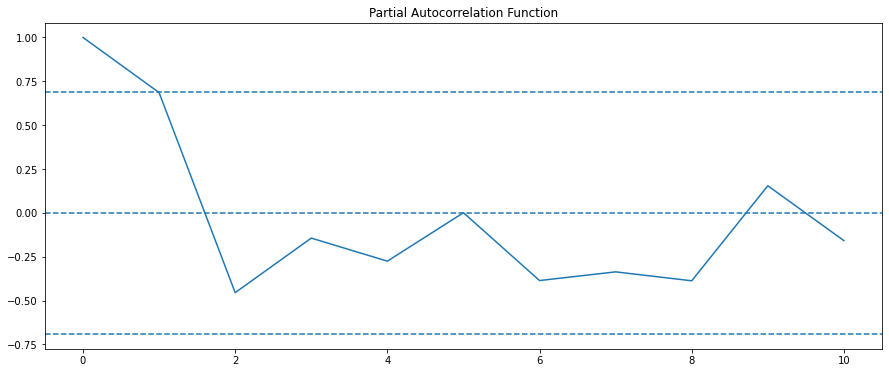

We see that p can be 0 or 1


In [64]:
# Plot PACF
plt.plot(np.arange(11), pacf(ts_log_mov_diff, nlags=10))
plt.axhline(y=0, linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mov_diff)), linestyle='--')
plt.title("Partial Autocorrelation Function")
plt.show()

print("We see that p can be 0 or 1")

## Building Model

In [66]:
# Instanciate the arima model
from statsmodels.tsa.arima.model import ARIMA

In [89]:
model = ARIMA(ts_log_mov_diff, order=[1, 1, 0])

In [90]:
result_model = model.fit()

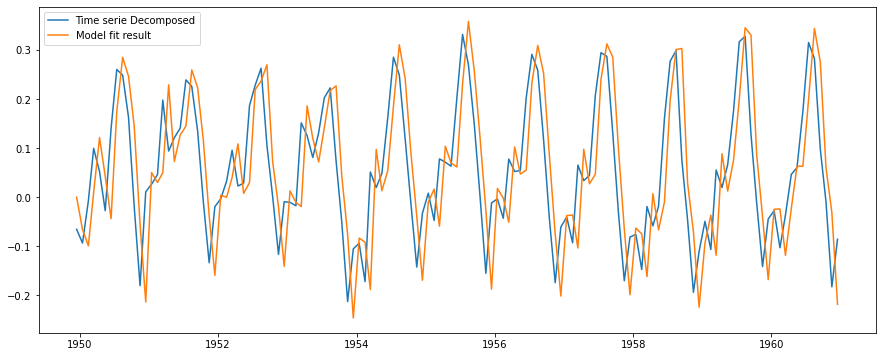

In [91]:
# display the result
plt.plot(ts_log_mov_diff, label='Time serie Decomposed')
plt.plot(result_model.fittedvalues, label='Model fit result')
plt.legend()

In [92]:
result_model.fittedvalues

Month
1949-12-15    0.000000
1950-01-15   -0.065494
1950-02-15   -0.099182
1950-03-15    0.010047
1950-04-15    0.121355
                ...   
1960-08-15    0.343886
1960-09-15    0.275639
1960-10-15    0.060475
1960-11-15   -0.031269
1960-12-15   -0.218263
Length: 133, dtype: float64

In [93]:
ts_log_mov_diff

Month
1949-12-15   -0.065494
1950-01-15   -0.093449
1950-02-15   -0.007566
1950-03-15    0.099416
1950-04-15    0.052142
                ...   
1960-08-15    0.282363
1960-09-15    0.098235
1960-10-15   -0.009230
1960-11-15   -0.182690
1960-12-15   -0.085789
Name: #Passengers, Length: 133, dtype: float64

In [99]:
prediction_arima_diff = pd.Series(result_model.fittedvalues, copy=True)

In [100]:
prediction_arima_diff

Month
1949-12-15    0.000000
1950-01-15   -0.065494
1950-02-15   -0.099182
1950-03-15    0.010047
1950-04-15    0.121355
                ...   
1960-08-15    0.343886
1960-09-15    0.275639
1960-10-15    0.060475
1960-11-15   -0.031269
1960-12-15   -0.218263
Length: 133, dtype: float64

<AxesSubplot:xlabel='Month'>

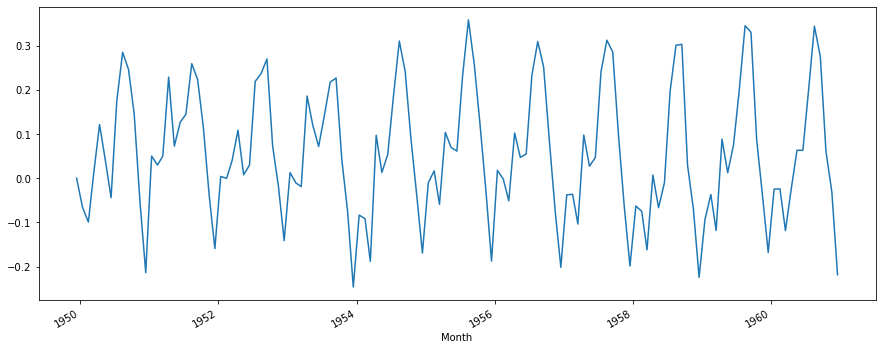

In [101]:
prediction_arima_diff.plot()

In [104]:
print(result_model.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 110.918
Date:                Thu, 18 Aug 2022   AIC                           -217.835
Time:                        12:41:43   BIC                           -212.069
Sample:                             0   HQIC                          -215.492
                                - 133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2051      0.091      2.248      0.025       0.026       0.384
sigma2         0.0109      0.002      5.772      0.000       0.007       0.015
Ljung-Box (L1) (Q):                   0.18   Jarque-

In [97]:
import mglearn

In [98]:
citibike = mglearn.datasets.load_citibike()

In [105]:
citibike

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
                       ..
2015-08-31 09:00:00    16
2015-08-31 12:00:00     8
2015-08-31 15:00:00    17
2015-08-31 18:00:00    22
2015-08-31 21:00:00     7
Freq: 3H, Name: one, Length: 248, dtype: int64

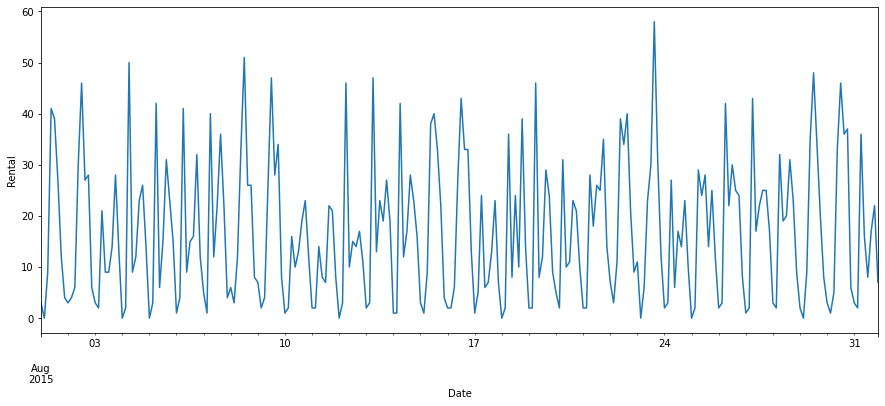

In [108]:
citibike.plot()
plt.xlabel("Date")
plt.ylabel('Rental')
plt.show()

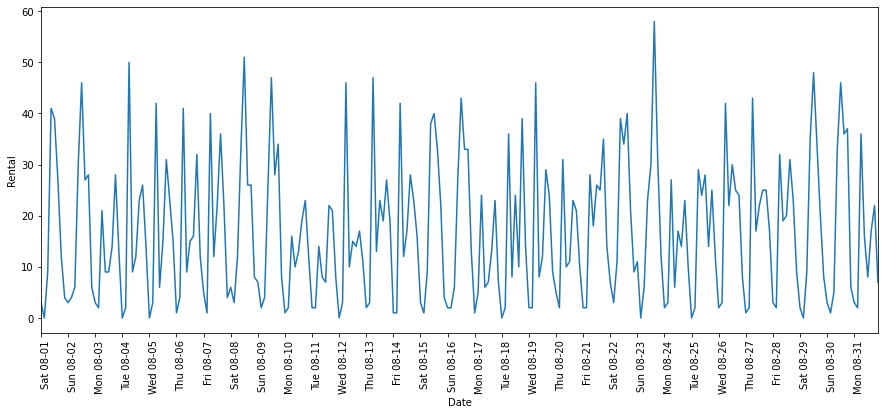

In [119]:
y      = citibike.values
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max())
citibike.plot()
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.xlabel("Date")
plt.ylabel("Rental")
plt.show()

In [140]:
# Convert into time POSIX
X = citibike.index.strftime('%s').astype('int').values.reshape(-1, 1)
y = citibike.values
n_train = 184

In [143]:
# Function to evaluate a regressor on a given set
def eval_on_features(features, target, regressor):
    # Splitting data
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], features[n_train:]
    
    #Fitting model
    regressor.fit(X_train, y_train)
    print("Test R^2 score: ", regressor.score(X_test, y_test))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    # Plotting and visualize the result
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '--', label="Prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '--', label='Prediction test')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Rental")
    plt.show()

In [144]:
# Building the model
from sklearn.ensemble import RandomForestRegressor

In [145]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)

Test R^2 score:  -52147508.20446107


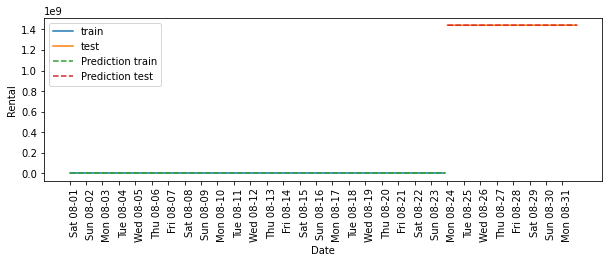

In [146]:
# Applying evaluate model Function
eval_on_features(X, y, regressor)

In [147]:
def eval_on_features_2(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
                    ha="left")
    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
                            label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


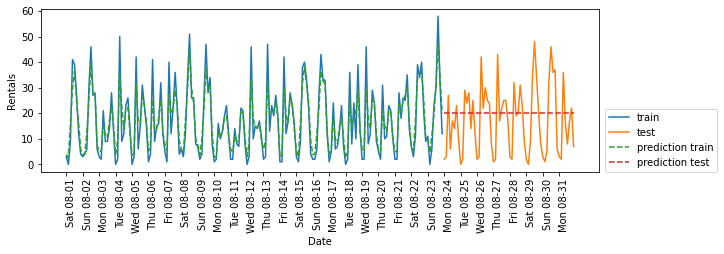

In [148]:
eval_on_features_2(X, y, regressor)

In [150]:
# Convert data in hour
X_hour = citibike.index.hour.values.reshape(-1, 1)

Test-set R^2: 0.60


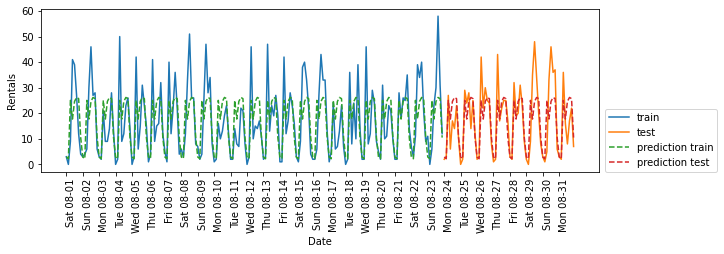

In [151]:
eval_on_features_2(X_hour, y, regressor)

In [154]:
#day of week and hour of day
X_week_hour = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), X_hour])

Test-set R^2: 0.84


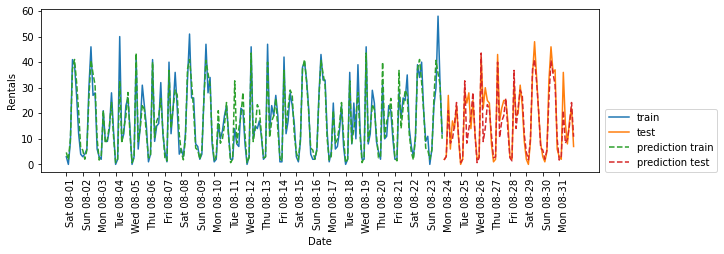

In [155]:
eval_on_features_2(X_week_hour, y, regressor)

In [156]:
model = RandomForestRegressor(n_estimators=100, random_state=0)
model.fit(X_week_hour, y)

RandomForestRegressor(random_state=0)

In [157]:
from datetime import datetime as dt

In [158]:
now = dt.now()

In [160]:
now

datetime.datetime(2022, 8, 18, 15, 10, 9, 71536)

In [170]:
data = [now.weekday(), now.day]
data = np.array(data).reshape(1, -1)
data

array([[ 3, 18]])

In [171]:
model.predict(data)

array([25.82898016])